In [5]:
import numpy as np
import pandas as pd
from numpy.random import randn
np.random.seed(101)
DATA_DIR = '/Users/nathanzhao/Desktop/Python_quant_finance' + \
        '/Python-for-Finance-Repo-master-master' + \
        '/05-Pandas-with-Time-Series' +\
        '/time_data'
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
%matplotlib inline

# Catalog:
* ### Datetime index
* ### Time Resampling & aggregate visualization
* ### Time shifting
* ### Rolling & Expanding

================================================
================================================

# Date-time index
* Python built-in
* Pandas Datetime Index: built on python built-in

### Python built-in

In [11]:
from datetime import datetime

# Create date time
my_date = datetime(year = 2017, month = 1, day = 2)
my_date_time = datetime(year = 2017, month = 1, day = 2, hour = 13, minute = 30, second = 15)
type(my_date_time)

# Can invoke attributes of datetime object
my_date_time.day

datetime.datetime

### Pandas Datetime Index
* 【 pd.DatetimeIndex([..]) 】

In [32]:
# Create Index object
first_two  = [datetime(2016,1,1), datetime(2016,1,2)]
dt_ind = pd.DatetimeIndex(first_two)

In [31]:
data = np.random.randn(2,2)
df = pd.DataFrame(data = data, index = dt_ind, columns = ['a', 'b'])

df.index.argmax()
df.index.max()

Timestamp('2016-01-02 00:00:00')

-------------
-------------

# Time Resampling & aggregate visualization
* Read df (time as just a column for now), Convert time column to Datetime object
* Resampler: 'groupby' object specific to time series
* Resample with visualization 

### Read df (time as just a column for now), Convert time column to Datetime object
* 【 pd.to_datetime(..) 】: arg, format
* 【 df.info() 】

In [228]:
df = pd.read_csv(DATA_DIR + '/walmart_stock.csv')
# df.info() 
# ===> Note: 'Date' column is 'non-null object', not a time series object yet.

df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')
# df.info()
# ===> 'Date' column is of datetime64[ns] now.
# OR
df['Date'] = df['Date'].apply(    lambda x : pd.to_datetime(x, format = '%Y-%m-%d')    )

# Now can set this column to index
df.set_index('Date', inplace = True)

### Resampler: 'groupby' object specific to time series
* Look up: "All possible time series offset strings"

In [229]:
print(\
df.resample(rule = 'A'))
df.resample(rule = 'A').mean()      .shape

DatetimeIndexResampler [freq=<YearEnd: month=12>, axis=0, closed=right, label=right, convention=start, base=0]


(5, 6)

In [230]:
#  Define my own rule for resampling

def first2_day(entry):
    return entry.iloc[0:2]
print( df.resample(rule = 'A').apply(first2_day)      .shape)

def first2_day_2_col(entry):
    return entry.iloc[0:2][['Open', 'High']]
df.resample(rule = 'A').apply(first2_day_2_col)      .shape 

(10, 6)


(10, 2)

### Resample with visualization 
* 【 unstack().transpose() 】 & 【 lambda x: x[0:-1] 】to plot groups side by side along x-axis

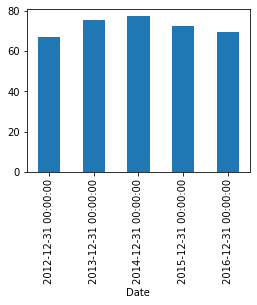

In [231]:
ax = df['Close'].resample(rule = 'A').mean().plot.bar(figsize = (4,3))

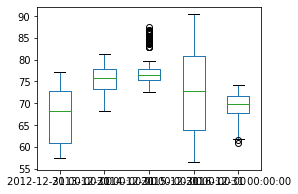

In [232]:
# GOOD!!!!
unstacked = df['Close'].resample(rule = 'A').apply(lambda x:x[0:-1]).unstack().transpose()
unstacked.plot.box(figsize = (4,3))

-------------
-------------

# Time Shifting
* Shifting
* t-shifting (like a groupby, but synchronize index within groups)

### Shifting 
* argument: periods (+/-)

In [255]:
df.shift(periods = 1)    .head(3)

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-04,59.970001,61.060001,59.869999,60.330002,12668800.0,52.619235
2012-01-05,60.209999,60.349998,59.470001,59.709999,9593300.0,52.078475


### t-shifting (like a groupby, but synchronize index within groups)
* argument: freq ('M','A')

In [256]:
df.tshift(freq = 'M').head(3)

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2012-01-31,59.970001,61.060001,59.869999,60.330002,12668800,52.619235
2012-01-31,60.209999,60.349998,59.470001,59.709999,9593300,52.078475
2012-01-31,59.349998,59.619999,58.369999,59.419998,12768200,51.825539


-------------
-------------

# Rolling and Expanding
* Rolling Mean: (Window Aggregate)
* Expanding Mean: (Everything before Aggregate)
* (E.G.) Bollinger Bands

### Rolling Mean: (Window Aggregate)
* arguments: window
* 1. the day-to-day date is too noisy
* 2. larger the wondow, more focusing on the general trend

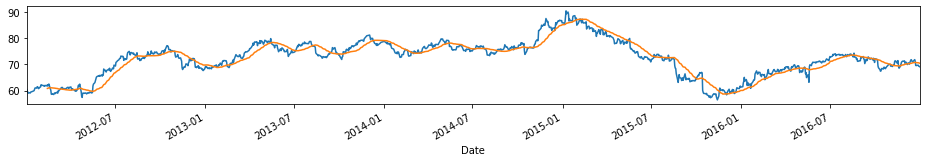

In [275]:
df['Close'].plot.line()
df.rolling(window = 30).mean()['Close'].plot.line(figsize = (16,2))

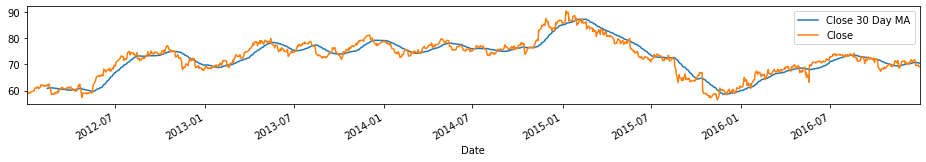

In [278]:
# Add legend: make this rolling value a new column, then pandas will auto-add a legend
df['Close 30 Day MA'] = df['Close'].rolling(window = 30).mean()
df[['Close 30 Day MA', 'Close']].plot(figsize = (16,2))

### Expanding Mean: (Everything before Aggregate)
* arguments: min_periods

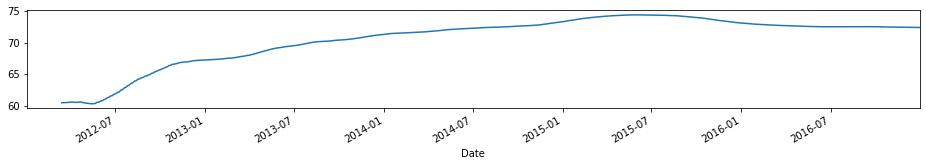

In [283]:
df['Close'].expanding(min_periods = 50).mean().plot.line(figsize = (16,2))

### (E.G.) Bollinger Bands: 
* volatility bands placed above and below a moving average
    * volatility based on standard deviation
* used to identify tops & bottoms, & determine strength of actual trend 
    * whether a price movement is significant or not
    * whether a price is really low compared to previous ones

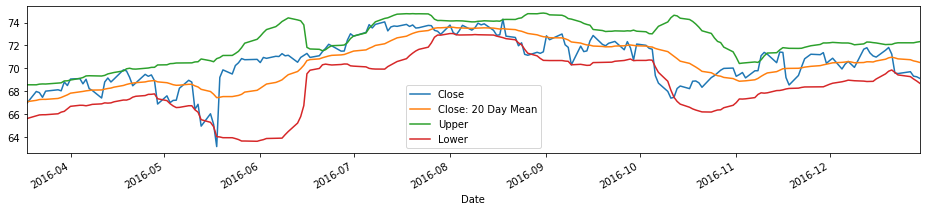

In [289]:
# Need to create 3 columns and put closing price along with it

# 1. Close 20 MA
df['Close: 20 Day Mean'] = df['Close'].rolling(20).mean()

# 2. Upper = 20MA + 2 * std(20)
df['Upper'] = df['Close: 20 Day Mean'] + 2 *df['Close'].rolling(20).std()

# 3. Upper = 20MA - 2 * std(20)
df['Lower'] = df['Close: 20 Day Mean'] - 2 *df['Close'].rolling(20).std()

# Plot:
df[['Close', 'Close: 20 Day Mean', 'Upper', 'Lower']].tail(200).plot(figsize = (16,3))